<h1 align="center">Volume 3: Data Augmentation.</h1>

    Everett Bergeson
    Section #
    10/31/2021

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
from sklearn import datasets
import numpy as np
from imageio import imread
import cv2
import librosa
import librosa.display
from sklearn.metrics import confusion_matrix

<h2 align="center">Image Augmentation</h2>

<h3 align="center">Problem 1</h3>

In [2]:
def translate(image, A, B): 
    """Returns each image translated by a random amount (a,b), where
    a~Uniform(-A,A) and b~Uniform(-B,B). The resulting image should be cropped
    to be of size (d1,d2). Note that this translation will leave a border on
    two sides of the image. Fill the empty border with the parts that were cropped
    off the opposite sides.
        Parameters:
            image (d1,d2): d1 x d2 array 
            A (float): horizontal translation parameter
            B (float): vertical translation parameter
        Returns:
            translated_image (d1,d2): array of translated image
    """
    d1, d2 = image.shape
    # Choose random angle
    a = int(np.random.uniform(-A, A))
    b = int(np.random.uniform(-B, B))
    
    image = np.roll(image, a, axis=0) # shift 1 place in horizontal axis
    image = np.roll(image, b, axis=1)
    return image
        
def rotate(image, theta): 
    """ Returns an image rotated by a random amount t~Uniform(-theta,theta).
    The resulting image should be cropped to be the same size as the original,
    and any blank parts should be filled with one of the parts cropped off the
    other side.
        Parameters:
            image (d1,d2): d1 x d2 array
            theta (float): largest acceptable rotation angle
        Returns:
            rotated_image (d1,d2): array of rotated image
    """
    # Choose rotate angle, make matrix
    t = np.random.uniform(-theta, theta)
    rot_mat = np.array([[np.cos(t), -np.sin(t)],
                        [np.sin(t), np.cos(t)]])
    
    # Get coordinate matrix
    d1, d2 = image.shape
    coords = np.mgrid[0:d1, 0:d2].reshape((2, d1*d2))
    
    # Find new coordinates
    new_coords = rot_mat @ coords
    new_coords = new_coords.astype(int)

    # Re-create image
    x, y = new_coords.reshape((2, d1, d2), order='F')
    return np.take(image, x+d1*y, mode='wrap').reshape((d1, d2))
    
def skew(image, A): 
    """ Returns an image with the linear transformation [[1,a],[0,1]] applied,
    where a~Uniform(-A,A). Crop the parts that go outside the image boundaries
    and fill missing areas with the appropriate cropped piece.
        Parameters:
            image (d1,d2): d1 x d2 array
            A (float): skew parameter
        Returns:
            skewed_image (d1,d2): array of skewed image
    """
    # Choose skew angle
    a = np.random.uniform(-A, A)
    skew_mat = np.array([[1, a],
                         [0, 1]])
    
    # Get coordinate matrix
    d1, d2 = image.shape
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    
    # Find new coordinates
    new_coords = skew_mat @ coords
    new_coords = new_coords.astype(int)

    x, y = new_coords.reshape((2, d2, d1), order='F')
    return np.take(image, x+d1*y, mode='wrap').reshape((d1, d2))

def flip_horizontal(image):
    """Flip horizontal. Returns a horizontally flipped version of each image.
        Parameters:
            images (d1,d2): d1 x d2 image array 
        Returns:
            flipped_image (d1,d2): array of flipped image
    """
    return np.flip(image, axis=1)
    

def gauss_noise(image, sigma2): 
    """Adds Gaussian noise with parameter sigma2. For each image draw d1xd2 random
    noise values from N(0,sigma2) and add those to the original image.
        Parameters:
            images (d1,d2): d1 x d2 array 
        Returns:
            noisy_image: array of noisy image
    """
    d1, d2 = image.shape
    noise_mat = np.random.normal(0, sigma2, (d1, d2))
    return image + noise_mat

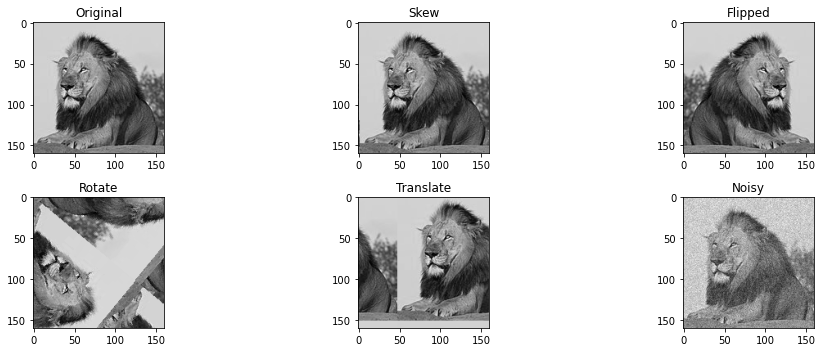

In [3]:
# lion = imread('lion.jpg')
# gray = cv2.cvtColor(lion, cv2.COLOR_BGR2GRAY)
gray = imread('lion.png')
fig, axs = plt.subplots(2, 3, figsize=(15,5))
axs[0, 0].imshow(gray, cmap='gray')
axs[0, 0].set_title('Original')
axs[0, 1].imshow(skew(gray, .5), cmap='gray')
axs[0, 1].set_title('Skew')
axs[0, 2].imshow(flip_horizontal(gray), cmap='gray')
axs[0, 2].set_title('Flipped')
axs[1, 0].imshow(rotate(gray, 5), cmap='gray')
axs[1, 0].set_title('Rotate')
axs[1, 1].imshow(translate(gray, 200, 200), cmap='gray')
axs[1, 1].set_title('Translate')
axs[1, 2].imshow(gauss_noise(gray, 20), cmap='gray')
axs[1, 2].set_title('Noisy')

plt.tight_layout()

<h3 align="center"> Problem 2 </h3>
Take the sklearn digits dataset, make an 80-20 train-test split, then apply 
each of your transformations to the entire training set. You must decide good 
values of each of the parameters to use---justify each choice.
This should give you a larger (augmented) training set with roughly 8,600 
training points. Fit a random forest to the augmented training set and to the 
original training set and return the results of each on the test set. 

In [10]:
def image_augment(X,Y,parameters):
    """ transform the images using the functions above. 
    Parameters:
        X (N,d1,d2): array containing N images of dimension d1 x d2
        Y (N,): Labels/values for each image
        parameters: List of parameter values [A,B,theta,A,sigma2]
    Returns:
        augmented_X (6N,d1,d2): original and transformed data in one array 
        augmented_Y (6N): corresponding labels/values
    """
    aug_images = []
    aug_labels = []
    A_, B_, theta, A, sigma2 = parameters
    for i, image in enumerate(X):
        # Original, Translate, Rotate, Skew, Flip, Gaussian
        aug_images.append(image)
        aug_images.append(translate(image, A_, B_))
        aug_images.append(rotate(image, theta))
        aug_images.append(skew(image, A))
        aug_images.append(flip_horizontal(image))
        aug_images.append(gauss_noise(image, sigma2))
        
        #Create 6 copies of the label to append
        for _ in range(6):
            aug_labels.append(Y[i])
        
    return np.array(aug_images), np.array(aug_labels)

# Parameters:
# We want it to only be translated by +- 1.5 pixel
# We only want it rotated +- 10 degrees so it doesn't
# become a different number
# Only skew by .1
# Only add +- 20 noise
parameters = [1.5, 1.5, .1, .1, 20]
# Get digits
digits = datasets.load_digits()
X = digits.images
y = digits.target

# Create forest
forest = RandomForestClassifier()
# Split training, test
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
# Augment training
X_train, y_train = image_augment(X_train, y_train,
                                parameters)
# Fit forest
forest.fit(X_train.reshape(-1, 64), y_train)
#Score Forest
print("Augmented Forest:")
print(round(forest.score(X_test.reshape(-1, 64), y_test), 5))

#####################################
# Create forest
forest1 = RandomForestClassifier()
# Split training, test
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
# Fit forest
forest1.fit(X_train.reshape(-1, 64), y_train)
#Score Forest
print("Original Forest")
print(round(forest1.score(X_test.reshape(-1, 64), y_test), 5))

Augmented Forest:
0.98333
Original Forest
0.97778


<h2 align="center">Audio Augmentation</h2>

<h3 align="center"> Problem 3 </h3>
The file music.npy contains the audio time series data from 10 second clips of 150 different songs, with style.npy describing the associated style of ballroom dance. The styles included are Chacha, Foxtrot, Jive, Samba, Rumba, and Waltz. Use train_test_split
from sklearn.model_selection with test_size=.5 to create train and test sets. Create two training sets by augmenting this original training set. Each new augmented
training set will include the original data and the augmented data. For the first, add ambient
noise from the file restaurant-ambience.wav. For the second, use time_stretch.

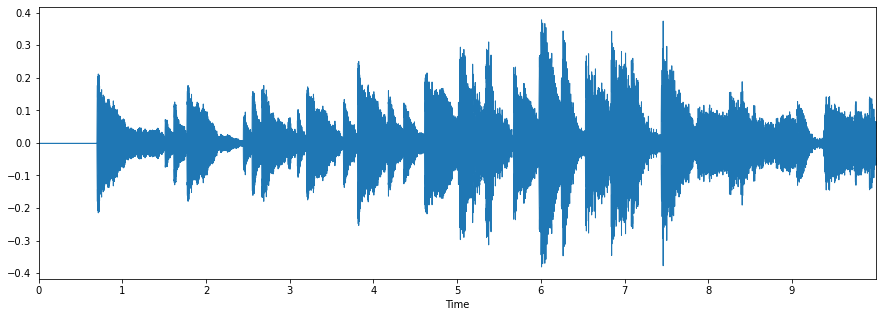

In [11]:
# load the audio time series and sampling rate
chopin, sample_rate = librosa.load('chopin.wav', sr = 22050)
plt.figure(figsize = (15,5))
librosa.display.waveplot(chopin,sample_rate) #generate plot
plt.show()

In [56]:
songs = np.load("music.npy")
labels = np.load("styles.npy")

X_train, X_test, y_train, y_test = train_test_split(
        songs, labels, test_size=0.5, random_state=42)

ambient, sample_rate = librosa.load('restaurant-ambience.wav')
X_stretched = []
X_ambient = []

for song in X_train:
    # Create time stretched
    X_stretched.append(librosa.effects.time_stretch(song, .98)[:len(song)])
    
    # Create ambient noise
    start = np.random.randint(0, len(ambient) - len(song))
    rand_amb = ambient[start:start + len(song)]
    
    # Add ambient noise
    X_ambient.append(song + rand_amb)
    
pulse_orig = []
pulse_amb = []
pulse_stretch = []
pulse_test = []
for i in range(len(X_train)):
    pulse_orig.append(librosa.beat.plp(X_train[i]))
    pulse_amb.append(librosa.beat.plp(X_ambient[i]))
    pulse_stretch.append(librosa.beat.plp(X_stretched[i]))

pulse_test = []
for i in range(len(X_test)):
     pulse_test.append(librosa.beat.plp(X_test[i]))

C:\Users\bergm\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=384 is too small for input signal of length=216
  warnings.warn(


<h3 align="center"> Problem 4</h3>

Do the following steps 5 times:

• Use the original data set and the augmented data sets to fit three RandomForestClassifiers,
one only on the original data, one on the original data and the data with ambient noise
added, and one on the original data and the time stretched data.

• Score each classifier.

Print the mean score for each of the classifiers and print the standard deviation for the scores.


In [61]:
orig = []
amb = []
time = []
for i in range(5):
    # Fit original
    forest1 = RandomForestClassifier()
    forest1.fit(pulse_orig, y_train)
    orig.append(forest1.score(pulse_test, y_test))
    # Fit ambient noise
    forest2 = RandomForestClassifier()
    forest2.fit(pulse_amb, y_train)
    amb.append(forest2.score(pulse_test, y_test))
    # Fit time stretched
    forest3 = RandomForestClassifier()
    forest3.fit(pulse_stretch, y_train)
    time.append(forest3.score(pulse_test, y_test))
time = np.array(time)
orig = np.array(orig)
amb = np.array(amb)
print('\t\t Mean \t STD')
print('Original','\t',np.round(orig.mean(),3),'\t',np.round(orig.std(),3))
print('Ambient Noise','\t',np.round(amb.mean(),3),'\t',np.round(amb.std(),3))
print('Time Stretch:','\t',np.round(time.mean(),3),'\t', np.round(time.std(),3))


		 Mean 	 STD
Original 	 0.493 	 0.019
Ambient Noise 	 0.557 	 0.02
Time Stretch: 	 0.421 	 0.023


<h2 align="center">SMOTE</h2>

<h3 align="center"> Problem 5 </h3>

Write a function that uses the synthetic minority oversampling technique to augment an imbalanced data set.
Your function should have the following characteristics:

Accept $X$, a matrix of minority class samples
       $N$, the number of samples to generate per original point
       $k$, the number of nearest neighbors.

For each original point in the sample, pick one of the $k$ nearest neighbors at random and generate a new point that lies between the two original values. 

Return an array containing the synthetic samples.


In [2]:
def smote(X,N,k):
    """ Generate synthetic points using the SMOTE method. Hint! Use KDTree :)
    Parameters:
        X (n,m): minority class samples
        N (int): number of samples to generate from each point
        k (int): number of nearest neighbors
    Returns:
        synthetic ndarray(N*n,m): synthetic minority class samples
    """
    tree = KDTree(X)
    # Find nearest neighbors
    _, ind = tree.query(X,k+1)
    # Drop itself cuz we don't care about itself as a nearest neighbor
    ind = ind[:,1:]
    # Choose a random one of the neighbors
    col_choice = np.random.randint(0,k,len(X))
    chosen_index = [ind[i,j] for i,j in enumerate(col_choice)]
    chosen_neighbors = X[chosen_index]
    new_points = []
    for x, random_nn in zip(X, chosen_neighbors):
        # Pick N points between that point and its neighbor
        max_ = np.maximum(x, random_nn)
        min_ = np.minimum(x, random_nn)
        randoms = np.random.uniform(max_, min_, size=(N,len(x)))
        new_points.append(randoms)
    
    return new_points

<h3 align="center"> Problem 6 </h3>

The dataset found in creditcard.npy contains information about credit card purchases made over a two day period. 
Of the approximately 285,000 observations, 492 are fraudulent purchases. 
The last column indicates if the purchase was valid (0) or fraudulent (1). 

Do the following steps 10 times:

• Create a training and test set from the data using train_test_split from sklearn.
model_selection with test_size=.7.

• Use smote with N = 500 and k = 2 to augment the training set.

• Create two Gaussian Naïve Bayes classifiers (from sklearn.naive_bayes.GaussianNB),
one which wil be trained on only the original data and the other on the SMOTE augmented
data and the original data.

• Fit each classifier and find the recall and accuracy of each model.

Print the mean recall and mean accuracy of each model and and describe the findings.

In [25]:
creditcard = np.load('creditcard.npy')
features = creditcard[:,:-1]
labels = creditcard[:,-1]

total_orig_recall = 0
total_orig_score = 0
total_aug_recall = 0
total_aug_score = 0
for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        labels, 
                                                        test_size=0.7, 
                                                        random_state=42)
    X_fraud = X_train[y_train == 1]
    s = smote(X_fraud, 500, 2)
    clean_s = []
    for arr in s:
        for point in arr:
            clean_s.append(point)
    clean_s = np.array(clean_s)
    X_valid = X_train[y_train == 0]
    X_new_train = np.concatenate((X_valid, clean_s))
    y_new_train = np.append(np.zeros(len(X_valid)), np.ones(len(clean_s)))

    # Fit classifier with original training
    gauss_orig = GaussianNB()
    gauss_orig.fit(X_train, y_train)
    orig_score = gauss_orig.score(X_test, y_test)

    # Fit classifier with augmented 
    gauss_aug = GaussianNB()
    gauss_aug.fit(X_new_train, y_new_train)
    aug_score = gauss_aug.score(X_test, y_test)
    
    # Get original recall
    orig_predicted = gauss_orig.predict(X_test)
    CM_orig = confusion_matrix(y_test, orig_predicted)
    tp_orig = CM_orig[0][0]
    fn_orig = CM_orig[0][1]
    orig_recall = tp_orig / (tp_orig + fn_orig)
    
    # Get augmented recall 
    aug_predicted = gauss_aug.predict(X_test)
    CM_aug = confusion_matrix(y_test, aug_predicted)
    tp_aug = CM_aug[0][0]
    fn_aug = CM_aug[0][1]
    aug_recall = tp_aug / (tp_aug + fn_aug)

    total_orig_recall += orig_recall / 10
    total_orig_score += orig_score / 10
    total_aug_recall += aug_recall / 10
    total_aug_score += aug_score / 10

print('\t\t Recall \t Accuracy')
print('Original','\t',np.round(total_orig_recall,5),'\t', 
      np.round(total_orig_score,5))
print('SMOTE', '\t\t', np.round(total_aug_recall,5), '\t', 
      np.round(total_aug_score,5))

		 Recall 	 Accuracy
Original 	 0.9946 	 0.99402
SMOTE 		 0.99337 	 0.99296
